In [10]:
#In order to know the specific GPIB Instrument number for Keithley the code below is run and used:
import numpy as np
import pandas as pd
import pyvisa
import paramiko as pmk
rm = pyvisa.ResourceManager()
#rm.list_resources()
from pymeasure.instruments.keithley import Keithley2400 #Keithley class is 2400
# Next we import all necessary packages required for this experiment

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from time import sleep

In [11]:
Keithley = Keithley2400('GPIB0::24::INSTR')  
data_points = 25
averages = 50
max_current = 1e-3
min_current = 0.00
t = 20e-9 #thickness of the film

In [12]:
def line(currents, A, B):
    y = A*currents + B
    return y

In [13]:
#set RPi connection with PC through SSh  
ssh = pmk.SSHClient()
ssh.set_missing_host_key_policy(pmk.AutoAddPolicy())
piIP = "131.247.209.135"
ssh.connect(piIP,username = 'pi',password = 'AngMo->2021')

In [14]:
import time
LIA=rm.open_resource('GPIB0::13::INSTR')
LIA.write('AUXV 1,8 ') # set the voltage of power supply (KEPCO) #voltage and saturate the magnet
time.sleep(5.0)
LIA.write('APHS')#The  APHS  command  performs  the  Auto  Phase  function.This  commandis the same as pressing the [Auto Phase] key
LIA.write('AUXV 1, 8.0')#saturate the magnet
time.sleep(1)

In [15]:
loads = np.arange(-8,10,2) #setting the range and step of field

In [16]:
Hall_Pi_Voltage_list = []
Sheet_Resistance_List = []
for i in loads:
    LIA.write('AUXV 1 ,%.2f'%i)
    time.sleep(1)
    LIA.write('STRT')#this starts the data collection for the LIA 
    stdin,stdout,stderr = ssh.exec_command("cd Hallpi && python Hallpifinal.py")

    ID_Read = stdout.readline()
    #this line will read the first print in the python script (Hallpifinal) which reads ADS1256 reads sucess 
    Hall_voltage = stdout.readline()
    print(Hall_voltage)
    #this line will read the second print for Hall_voltage in the python script
    #Gaussmeter_voltage = stdout.readline()
    #this line will read the third print for Gaussmeter_voltage when (we will use it when we want to cal. the magnet) in the python script
    #measuring the MOKE signals from LIA
    #######################################
    MOKE_string=LIA.query('SNAP? 1,2')#this collects the data from X and Y from the LIA and returns it as a string
                    #X = MOKE signal, Y = background    
    MOKE_data = MOKE_string.split(',')#this splits the string up accordingly to get the values into an array

    #measuring the magneting voltage from Hall_pi
    ###############################################
    #Field (V)=Hall_voltage*Slpoe from magnet calibration

    temp = {"LIA_Voltage (V)": i,'Field  (V)':float(Hall_voltage)*float(5.44691536e+00),'Hall Pi Voltage (V)':float(Hall_voltage), 'MOKE Signal':float(MOKE_data[0]),'MOKE BCKGD':float(MOKE_data[1]),}
    #mydata = mydata.append(temp, #We build the results dataframe row by row by adding the temp array for every for loop/voltage
    #ignore_index =True)
    

# Set the input parameters

    
# Connect and configure the instrument

    Keithley.reset() #This command helps in resetting the Keithley for measurement and starts reading from zero.

#Since Kiethley has terminals both at the back and front, we must define what terminals are being used.
    Keithley.use_front_terminals()
    Keithley.measure_voltage() #Configures the measurement of voltage
    Keithley.apply_current() #Configures the instrument to apply a source current
    Keithley.source_current = min_current  # Sets the source current to min current mA
    Keithley.enable_source() # A boolean property that controls whether the source is enabled, takes values True or False.

#Keithley.config_buffer(averages) - this command is not necessary

    sleep(0.1) # wait here to give the instrument time to react

# Allocate arrays to store the measurement results
    currents = np.linspace(min_current, max_current, num=data_points)
    voltages = np.zeros_like(currents)
    voltage_stds = np.zeros_like(currents)
    sleep(0.1)

# Loop through each current point, measure and record the voltage
    for i in range(data_points):
        Keithley.start_buffer()
        Keithley.source_current = currents[i]
        sleep(0.1)
    # Record the average voltage and standard deviation
        voltages[i] = Keithley.voltage

    res = np.polyfit(voltages,currents,1)
    A = res[0]
    B = res[1]
    voltages = line(currents, A, B)
    Rs = (A * 4.53236)*t 
    
    Hall_Pi_Voltage_list.append(Hall_voltage)
    Sheet_Resistance_List.append(Rs)
    Keithley.reset()

-0.0339916344871

-0.0303891293274

-0.0241759404154

-0.0158950661296

-0.00772624858931

0.000634495930016

0.00881523440066

0.0152835312228

0.0186941094034



In [17]:
zipped = list(zip(Hall_Pi_Voltage_list, Sheet_Resistance_List))
zipped

[('-0.0339916344871\n', 1.0448814429502056e-09),
 ('-0.0303891293274\n', 1.0451211253236575e-09),
 ('-0.0241759404154\n', 1.0450360677381249e-09),
 ('-0.0158950661296\n', 1.0449411666513778e-09),
 ('-0.00772624858931\n', 1.0441509590507235e-09),
 ('0.000634495930016\n', 1.0449193618951746e-09),
 ('0.00881523440066\n', 1.0449399197325807e-09),
 ('0.0152835312228\n', 1.0449829309530738e-09),
 ('0.0186941094034\n', 1.045597183116266e-09)]

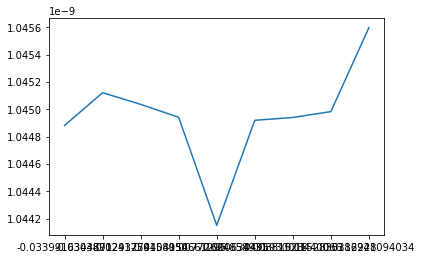

In [20]:
plt.plot(Hall_Pi_Voltage_list, Sheet_Resistance_List)

Parameters are equal to: 
 0.011534798461687357 
 -2.3838687177259963e-06


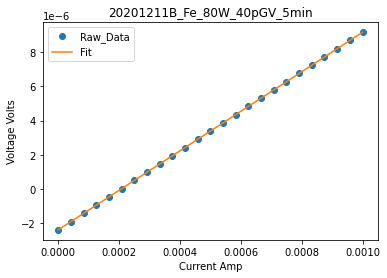

In [21]:
def line(currents, A, B):
    y = A*currents + B
    return y

parameters, cov = curve_fit(line, currents, voltages)

fit_A, fit_B = parameters[0], parameters[1]

print("Parameters are equal to: \n", fit_A, "\n", fit_B)

# Fit the data with found parameters
fit_voltages = line(currents, fit_A, fit_B)

# Plot the result of fitting
plt.plot(currents, voltages, 'o', label='Raw_Data')
plt.plot(currents, fit_voltages, '-', label='Fit')
plt.legend()
plt.xlabel("Current Amp")
plt.ylabel("Voltage Volts")
plt.title("20201211B_Fe_80W_40pGV_5min")
plt.show()

In [22]:
Rs =(fit_A*4.53236)*2e-9 
print (Rs, 'ohm cm')

1.0455971831162661e-10 ohm cm
